In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.constants as const
import astropy.constants as aconst
from time import monotonic

In [2]:
def phi(x,y,z):
    rii = np.sqrt(x**2+y**2+z**2+s**2)
    return -G*M/rii

def energy(x,y,z,vx,vy,vz,mi):
    vii = np.sqrt(vx**2+vy**2+vz**2)
    en_pot = phi(x,y,z)*mi
    en_kin = mi*vii**2/2.
    return en_pot, en_kin

def momentum(x,y,z,vx,vy,vz):
    rii = np.sqrt(x**2+y**2+z**2)
    vii = np.sqrt(vx**2+vy**2+vz**2)
    L2 = (rii**2*vii**2*(1-((x*vx+y*vy+z*vz)/(rii*vii))**2)) if (rii*vii) != 0 else 0
    return np.sqrt(L2)

def acc(x,y,z,ds):
    ax = -(phi(x+ds,y,z)-phi(x-ds,y,z))/(2*ds)
    ay = -(phi(x,y+ds,z)-phi(x,y-ds,z))/(2*ds)
    az = -(phi(x,y,z+ds)-phi(x,y,z-ds))/(2*ds)
    return ax, ay, az

def KDK(nsteps,r,v):
    en_pot[0], en_kin[0] = energy(r[0][0],r[1][0],r[2][0],v[0][0],v[1][0],v[2][0],mi)
    mom[0] = momentum(r[0][0],r[1][0],r[2][0],v[0][0],v[1][0],v[2][0])
    a[0][0], a[1][0], a[2][0] = acc(r[0][0],r[1][0],r[2][0],ds)
    a_max = np.sqrt(a[0][0]**2+a[1][0]**2+a[2][0]**2)
    dt = np.sqrt(2*eta*epsilon/a_max)
    for i in range(nsteps):
        # kick
        vi[:] = v[:,i]+a[:,i]*dt/2.
        # drift
        r[:,i+1] = r[:,i]+vi[:]*dt
        # kick
        a[0][i+1], a[1][i+1], a[2][i+1] = acc(r[0][i+1],r[1][i+1],r[2][i+1],ds)
        v[:,i+1] = vi[:]+a[:,i+1]*dt/2.
            
        a_max = np.sqrt(a[0][i+1]**2+a[1][i+1]**2+a[2][i+1]**2)
        dt = np.sqrt(2*eta*epsilon/a_max)
        t[i+1] = t[i]+dt

        en_pot[i+1], en_kin[i+1] = energy(r[0][i],r[1][i],r[2][i],v[0][i],v[1][i],v[2][i],mi)
        mom[i+1] = momentum(r[0][i],r[1][i],r[2][i],v[0][i],v[1][i],v[2][i])

    return t, r, v, a, en_pot, en_kin, mom

In [3]:
params = {'font.size': 16,
          'figure.figsize': (12.,8.),
          'axes.labelsize': 16,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16
         }
plt.rcParams.update(params)

# Spadek swobodny

In [4]:
pc = aconst.pc.value # m
m2pc = 1/pc
M_sun = aconst.M_sun.value # kg
kg2Ms = 1/M_sun
Myr = const.Julian_year*10**6 # s
s2Myr = 1/Myr
G = const.G*(m2pc)**3*(kg2Ms)**(-1)*(s2Myr)**(-2) # pc3 M_s-1 Myr-2
M = 10**12 # M_sun
mi = 1

time = 10e+4
dt = 1 # Myr
nsteps = int(time/dt)

ds = 0.1 # pc
s = 50

eta = 0.05 # pc
epsilon = 0.01

dim = 3
t = np.zeros(nsteps+1)
en_pot = np.zeros(nsteps+1)
en_kin = np.zeros(nsteps+1)
mom = np.zeros(nsteps+1)
r = np.zeros((dim,nsteps+1))
v = np.zeros((dim,nsteps+1))
a = np.zeros((dim,nsteps+1))
vi = np.zeros(dim)

r[0][0] = 8500. # pc
r[1][0] = 0.
r[2][0] = 0.

v[0][0] = 0.
v[1][0] = 0.
v[2][0] = 0.

start = monotonic()
t, r, v, a, en_pot, en_kin, mom = KDK(nsteps,r,v)
end = monotonic()
print(f"Czas kompilacji: {end-start} s")

Czas kompilacji: 5.402225724996242 s


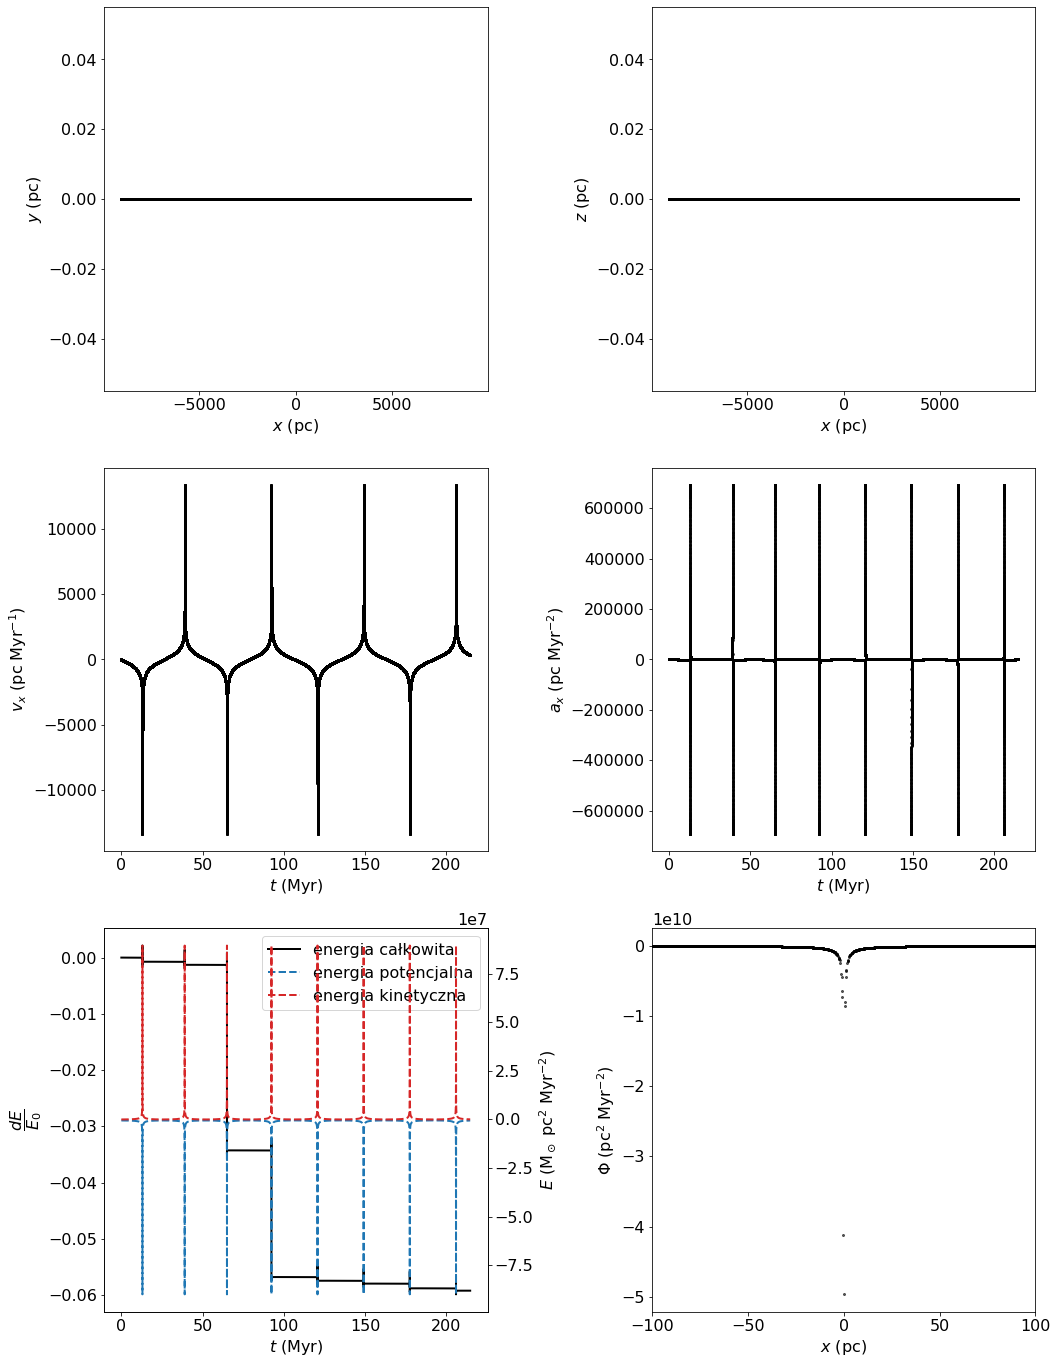

In [7]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(18,24))

ax[0,0].plot(r[0], r[1], ls='', marker='o', markersize=2, c='k', alpha=0.6)
ax[0,0].set_xlabel(r"$x$ (pc)")
ax[0,0].set_ylabel(r"$y$ (pc)")

ax[0,1].plot(r[0], r[2], ls='', marker='o', markersize=2, c='k', alpha=0.6)
ax[0,1].set_xlabel(r"$x$ (pc)")
ax[0,1].set_ylabel(r"$z$ (pc)")

ax[1,0].plot(t, v[0], ls='', marker='o', c='k', markersize=2, alpha=0.6)
ax[1,0].set_xlabel(r"$t$ (Myr)")
ax[1,0].set_ylabel(r"$v_x$ (pc Myr$^{-1}$)")

ax[1,1].plot(t, a[0], ls='', marker='o', c='k', markersize=2, alpha=0.6)
ax[1,1].set_xlabel(r"$t$ (Myr)")
ax[1,1].set_ylabel(r"$a_x$ (pc Myr$^{-2}$)")

tot = ax[2,0].plot(t, (en_pot+en_kin)/(en_pot[0]+en_kin[0])-1, ls='-', lw=2, c='k', label="energia całkowita")
ax[2,0].set_xlabel(r"$t$ (Myr)")
ax[2,0].set_ylabel(r"$\dfrac{dE}{E_0}$")

ax2=ax[2,0].twinx()
pot = ax2.plot(t, en_pot, ls='--', lw=2, c='tab:blue', label="energia potencjalna")
kin = ax2.plot(t, en_kin, ls='--', lw=2, c='tab:red', label="energia kinetyczna")
ax2.set_ylabel(r"$E$ (M$_\odot$ pc$^2$ Myr$^{-2}$)")

lns = tot+pot+kin
labs = [l.get_label() for l in lns]
lgnd = ax[2,0].legend(lns, labs, loc="best")

ax[2,1].plot(r[0], -G*M/np.sqrt(r[0]**2+r[1]**2+r[2]**2), ls='', marker='o', markersize=2, c='k', alpha=0.6)
ax[2,1].set_xlabel(r"$x$ (pc)")
ax[2,1].set_ylabel(r"$\Phi$ (pc$^2$ Myr$^{-2}$)")
ax[2,1].set_xlim(-100,100)

for i in range(3):
    for j in range(2):
        ax[i,j].set_box_aspect(1)

plt.savefig("ss2.png", dpi=300, bbox_inches='tight')

# Orbita kołowa

In [8]:
pc = aconst.pc.value # m
m2pc = 1/pc
M_sun = aconst.M_sun.value # kg
kg2Ms = 1/M_sun
Myr = const.Julian_year*10**6 # s
s2Myr = 1/Myr
G = const.G*(m2pc)**3*(kg2Ms)**(-1)*(s2Myr)**(-2) # pc3 M_s-1 Myr-2
M = 10**12 # M_sun
mi = 1

time = 10e+4
dt = 1 # Myr
nsteps = int(time/dt)

ds = 0.1 # pc
s = 50

eta = 0.05 # pc
epsilon = 0.01

dim = 3
t = np.zeros(nsteps+1)
en_pot = np.zeros(nsteps+1)
en_kin = np.zeros(nsteps+1)
mom = np.zeros(nsteps+1)
r = np.zeros((dim,nsteps+1))
v = np.zeros((dim,nsteps+1))
a = np.zeros((dim,nsteps+1))
vi = np.zeros(dim)

r[0][0] = 8500. # pc
r[1][0] = 0.
r[2][0] = 0.

r0 = np.sqrt(r[0][0]**2+r[1][0]**2+r[2][0]**2)
v[0][0] = 0.
v[1][0] = np.sqrt(G*M/r0)
v[2][0] = 0.

start = monotonic()
t, r, v, a, en_pot, en_kin, mom = KDK(nsteps,r,v)
end = monotonic()
print(f"Czas kompilacji: {end-start} s")

727.485771154125
Czas kompilacji: 5.680042558000423 s


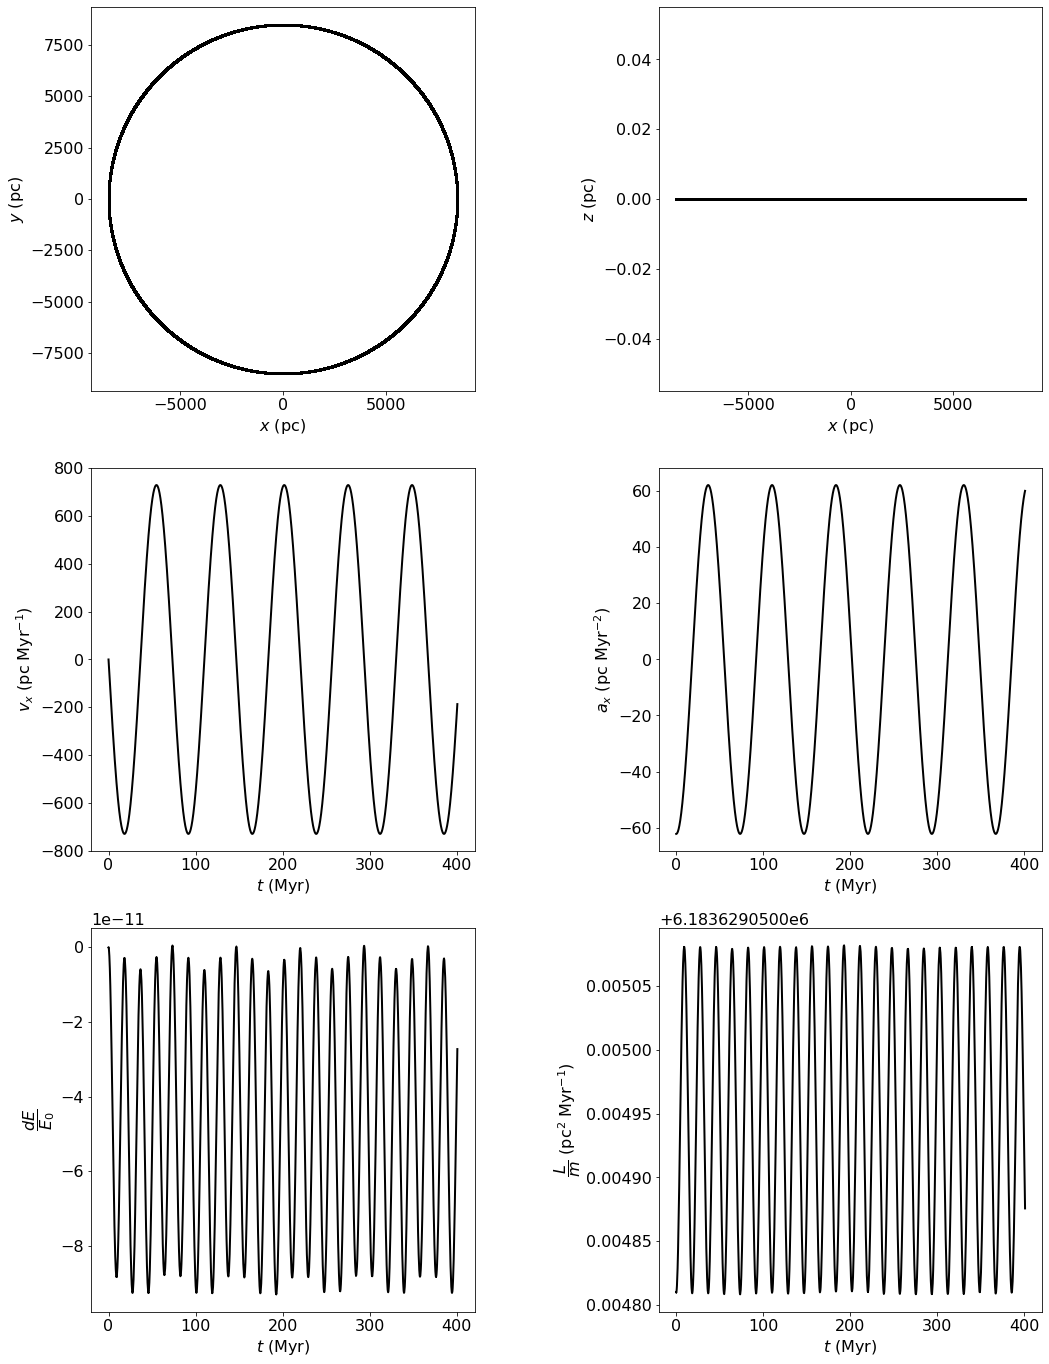

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(18,24))
fig.subplots_adjust(wspace=0.3)

ax[0,0].plot(r[0], r[1], ls='', marker='o', markersize=2, c='k', alpha=0.6)
ax[0,0].set_aspect('equal', 'box')
ax[0,0].set_xlabel(r"$x$ (pc)")
ax[0,0].set_ylabel(r"$y$ (pc)")

ax[0,1].plot(r[0], r[2], ls='', marker='o', markersize=2, c='k', alpha=0.6)
ax[0,1].set_xlabel(r"$x$ (pc)")
ax[0,1].set_ylabel(r"$z$ (pc)")

ax[1,0].plot(t, v[0], ls='-', lw=2, c='k')
ax[1,0].set_xlabel(r"$t$ (Myr)")
ax[1,0].set_ylabel(r"$v_x$ (pc Myr$^{-1}$)")

ax[1,1].plot(t, a[0], ls='-', lw=2, c='k')
ax[1,1].set_xlabel(r"$t$ (Myr)")
ax[1,1].set_ylabel(r"$a_x$ (pc Myr$^{-2}$)")

ax[2,0].plot(t, (en_pot+en_kin)/(en_pot[0]+en_kin[0])-1, ls='-', lw=2, c='k')
ax[2,0].set_xlabel(r"$t$ (Myr)")
ax[2,0].set_ylabel(r"$\dfrac{dE}{E_0}$")

ax[2,1].plot(t, mom, ls='-', lw=2, c='k')
ax[2,1].set_xlabel(r"$t$ (Myr)")
ax[2,1].set_ylabel(r"$\dfrac{L}{m}$ (pc$^2$ Myr$^{-1}$)")

for i in range(3):
    for j in range(2):
        ax[i,j].set_box_aspect(1)

plt.savefig("ok2.png", dpi=300, bbox_inches='tight')